In [1]:
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as optimize
import math

Gaussian Fit
Mean: 3.2986587039042523 +/- 0.10001784715510989
Std: 1.7570693851026076 +/- 0.0831501990210057
--------------------------------------------------
Poisson Fit
Mean: 3.5594060390758893 +/- 0.08449003938966732
Gaussian Fit
Mean: 3.374030527390262 +/- 0.0827847062308982
Std: 1.7470097104127453 +/- 0.06872276091841262
--------------------------------------------------
Poisson Fit
Mean: 3.633752345115593 +/- 0.0802487863618882
Gaussian Fit
Mean: 3.462660028336104 +/- 0.06263002473978521
Std: 1.7041990833721874 +/- 0.051843603226246746
--------------------------------------------------
Poisson Fit
Mean: 3.7055153604790787 +/- 0.09727835320371116
Gaussian Fit
Mean: 3.2986587039042523 +/- 0.10001784715510989
Std: 1.7570693851026076 +/- 0.0831501990210057
--------------------------------------------------
Poisson Fit
Mean: 3.5594060390758893 +/- 0.08449003938966732


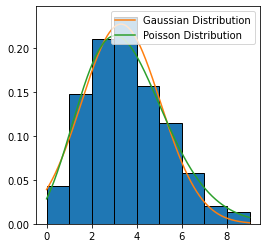

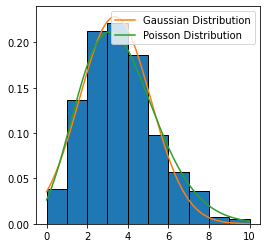

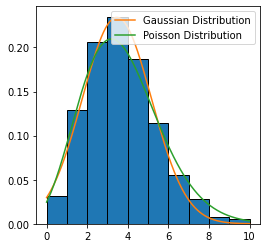

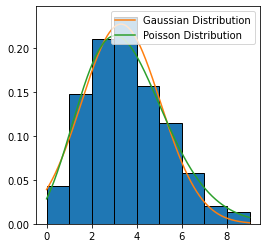

In [2]:
def Gaussian(x, mean, std):
    return (1/(std*(2*np.pi)**0.5))*np.exp(-(x-mean)**2/(2* std**2))
def Poisson(x,mu):
    return (mu**x/scipy.special.factorial(x)) * np.exp(-mu)

E1 = []
E1.append(np.genfromtxt("E1.csv", delimiter=",", usecols=(1), skip_header=1))
E1.append(np.genfromtxt("E1.csv", delimiter=",", usecols=(3), skip_header=1))
E1.append(np.genfromtxt("E1.csv", delimiter=",", usecols=(5), skip_header=1))
E1_sum = E1[0]
np.append(E1_sum,E1[1])
np.append(E1_sum,E1[2])
E1.append(E1_sum)
for x in E1:
    plt.figure(figsize=(4, 4))
    n,bins,patches = plt.hist(x, density=True, edgecolor='black', bins = np.arange(min(x),max(x),1)) #Define bin using arange on min max

    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n)
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n)
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    x = np.linspace(min(bins),max(bins),2000)
    plt.plot(x,Gaussian(x,gpopt[0],gpopt[1]),label='Gaussian Distribution')
    plt.plot(x,Poisson(x,ppopt[0]),label='Poisson Distribution')
    plt.legend(loc='upper right')
    plt.show

Gaussian Fit
Mean: 31.670947811483853 +/- 0.4389994669005671
Std: 5.43575671861399 +/- 0.36230903209962967
--------------------------------------------------
Poisson Fit
Mean: 31.87896242115413 +/- 0.4554295359323059
Gaussian Fit
Mean: 32.09391523329434 +/- 0.5424431281552532
Std: 5.457005178841131 +/- 0.44533344209650083
--------------------------------------------------
Poisson Fit
Mean: 32.37625155306646 +/- 0.5624136397099015
Gaussian Fit
Mean: 31.60429230071113 +/- 0.6812701335172477
Std: 6.058352999974206 +/- 0.5688662953016869
--------------------------------------------------
Poisson Fit
Mean: 31.942125422782528 +/- 0.6111366629990059
Gaussian Fit
Mean: 31.670947811483853 +/- 0.4389994669005671
Std: 5.43575671861399 +/- 0.36230903209962967
--------------------------------------------------
Poisson Fit
Mean: 31.87896242115413 +/- 0.4554295359323059


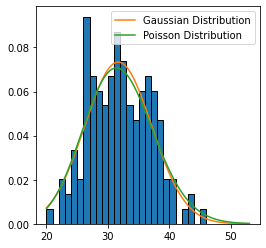

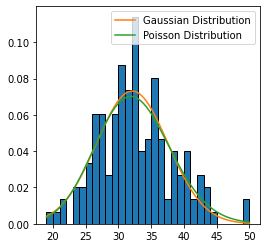

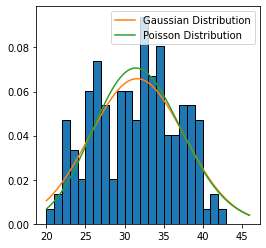

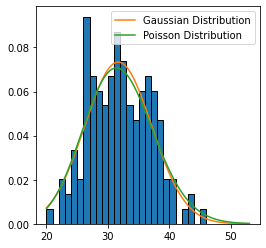

In [3]:
E2 = []
E2.append(np.genfromtxt("E2.csv", delimiter=",", usecols=(1), skip_header=1))
E2.append(np.genfromtxt("E2.csv", delimiter=",", usecols=(3), skip_header=1))
E2.append(np.genfromtxt("E2.csv", delimiter=",", usecols=(5), skip_header=1))
E2_sum = E2[0]
np.append(E2_sum,E2[1])
np.append(E2_sum,E2[2])
E2.append(E2_sum)
for x in E2:
    plt.figure(figsize=(4, 4))
    n,bins,patches = plt.hist(x, density=True, edgecolor='black', bins = np.arange(min(x),max(x),1)) #Define bin using arange on min max

    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n, p0=[30,5])
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n,p0=[30])
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    x = np.linspace(min(bins),max(bins),2000)
    plt.plot(x,Gaussian(x,gpopt[0],gpopt[1]),label='Gaussian Distribution')
    plt.plot(x,Poisson(x,ppopt[0]),label='Poisson Distribution')
    plt.legend(loc='upper right')
    plt.show

Gaussian Fit
Mean: 1.756699667982423 +/- 0.1501513383132711
Std: 1.2851816638950855 +/- 0.12384731705144572
--------------------------------------------------
Poisson Fit
Mean: 2.0421247965901097 +/- 0.13114738100330295
Gaussian Fit
Mean: 1.7658660496054412 +/- 0.08867009116032827
Std: 1.2338596688150592 +/- 0.0735036812805473
--------------------------------------------------
Poisson Fit
Mean: 2.0260815649200583 +/- 0.12658289904054318
Gaussian Fit
Mean: 1.8558414322721748 +/- 0.10409090718468103
Std: 1.288736054216973 +/- 0.08662520356706237
--------------------------------------------------
Poisson Fit
Mean: 2.115058769431287 +/- 0.12988345589865277
Gaussian Fit
Mean: 1.8411749555031436 +/- 0.10302498115080647
Std: 1.2600021624548479 +/- 0.08584161943213793
--------------------------------------------------
Poisson Fit
Mean: 2.0992965505281838 +/- 0.14130838099221096
Gaussian Fit
Mean: 1.8074890299126498 +/- 0.07895941820976461
Std: 1.3129448382976783 +/- 0.06496802637513688
-------

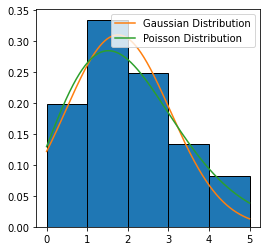

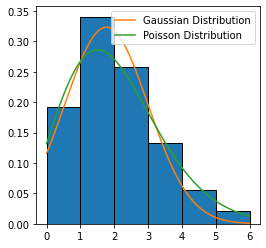

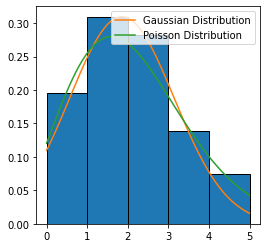

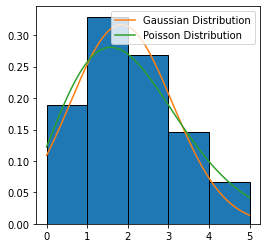

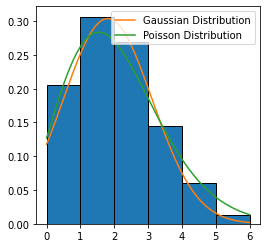

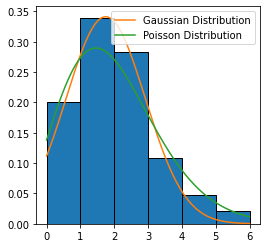

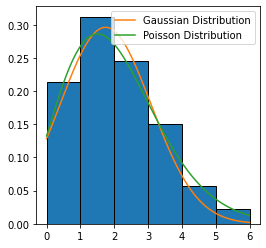

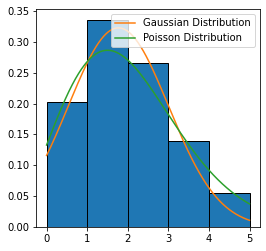

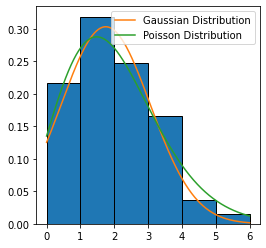

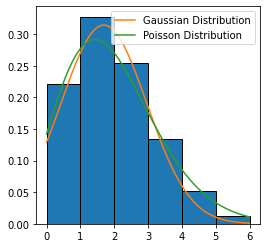

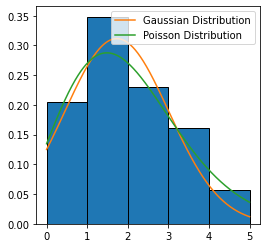

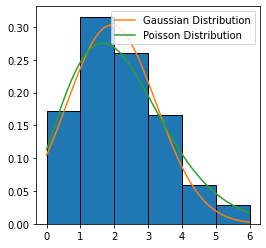

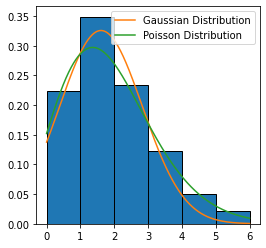

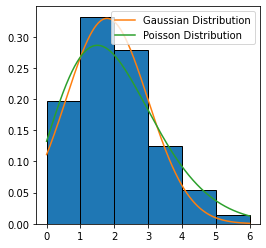

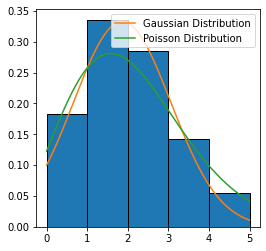

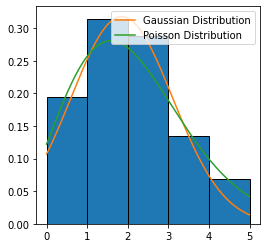

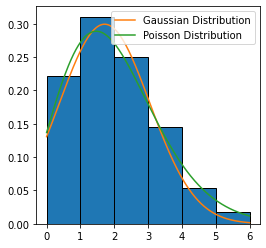

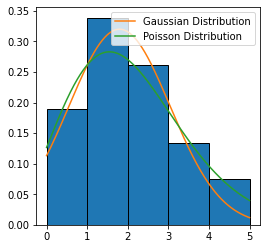

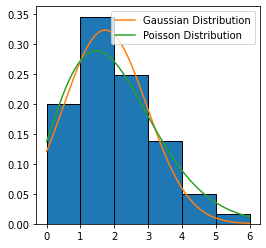

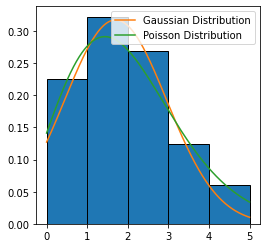

In [4]:
E3 = []
for i in range(1,41,2):
    E3.append(np.genfromtxt("E3.csv", delimiter=",", usecols=(i), skip_header=1))
for x in E3:
    plt.figure(figsize=(4, 4))
    n,bins,patches = plt.hist(x, density=True, edgecolor='black', bins = np.arange(min(x),max(x),1)) #Define bin using arange on min max

    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n, p0=[2,5])
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n,p0=[2])
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    x = np.linspace(min(bins),max(bins),2000)
    plt.plot(x,Gaussian(x,gpopt[0],gpopt[1]),label='Gaussian Distribution')
    plt.plot(x,Poisson(x,ppopt[0]),label='Poisson Distribution')
    plt.legend(loc='upper right')
    plt.show

Gaussian Fit
Mean: 7.041208171058124 +/- 0.7408033682895825
Std: 2.9213773075553773 +/- 0.5631247294009537
--------------------------------------------------
Poisson Fit
Mean: 7.27119882020625 +/- 0.6035161255954482
Gaussian Fit
Mean: 6.452466408015013 +/- 0.2142233583681363
Std: 2.143374168303067 +/- 0.1758947559049959
--------------------------------------------------
Poisson Fit
Mean: 6.726158554046492 +/- 0.3184003095847898
Gaussian Fit
Mean: 6.643314038639071 +/- 0.24426454165623673
Std: 2.7539309267177003 +/- 0.20555229090211152
--------------------------------------------------
Poisson Fit
Mean: 6.94418323154653 +/- 0.23745548952158108
Gaussian Fit
Mean: 6.477052871612779 +/- 0.0979777741729365
Std: 2.3918366134361606 +/- 0.08152326177494872
--------------------------------------------------
Poisson Fit
Mean: 6.742541124532978 +/- 0.13426593584577565
Gaussian Fit
Mean: 5.5077390091693665 +/- 0.35320249474603627
Std: 2.641375487326865 +/- 0.29519631825827275
---------------------

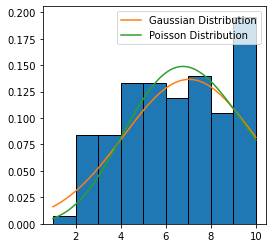

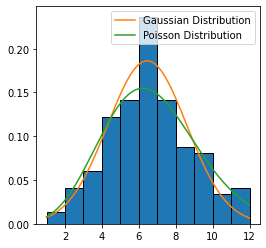

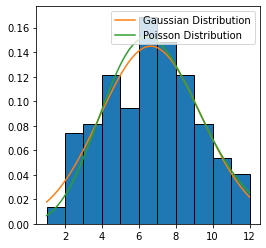

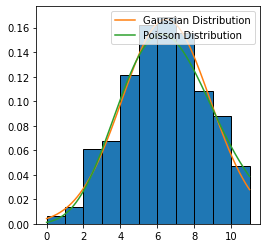

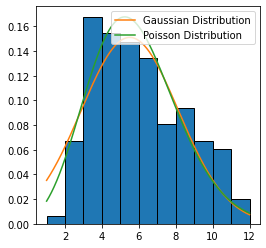

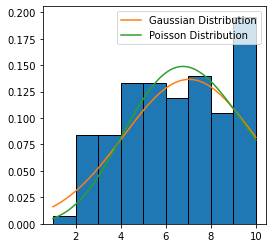

In [9]:
E4 = []
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(1), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(3), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(5), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(7), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(9), skip_header=1))
E4_sum = E4[0]
np.append(E4_sum,E4[1])
np.append(E4_sum,E4[2])
np.append(E4_sum,E4[3])
np.append(E4_sum,E4[4])
E4.append(E4_sum)
for x in E4:
    plt.figure(figsize=(4, 4))
    n,bins,patches = plt.hist(x, density=True, edgecolor='black', bins = np.arange(min(x),max(x),1)) #Define bin using arange on min max

    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n, p0=[6,1])
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n,p0=[6])
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    x = np.linspace(min(bins),max(bins),2000)
    plt.plot(x,Gaussian(x,gpopt[0],gpopt[1]),label='Gaussian Distribution')
    plt.plot(x,Poisson(x,ppopt[0]),label='Poisson Distribution')
    plt.legend(loc='upper right')
    plt.show